#### Example running SpaFHy with jupyter notebook

In [1]:
from model_driver import driver
from iotools import read_results
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

os.chdir(r'/projappl/project_2000908/nousu/SpaFHy_v2.0')

# example of calling driver, reading results
outputfile = driver(create_ncf=True, create_spinup=False, folder='testcase_input')
results = xr.open_dataset(outputfile)

*** Understory LAI assigned from LAI_decid and LAI_conif ***
*** Defined root soil IDs: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16} Used root soil IDs: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan, 12.0, 13.0, 14.0, 15.0, 16.0} ***
*** Defined organic soil IDs: {0, 1, 2, 3, 4} Used organic soil IDs: {0.0, 1.0, 2.0, 3.0, 4.0, nan} ***
*** State variables assigned from parameters.py ***
*** Simulation forced with: /projappl/project_2000908/nousu/SpaFHy_FORCING/HYYTIALA_FORCING_1980_2021.csv


/projappl/project_2000908/nousu/SpaFHy_v2.0/canopygrid.py:760: RuntimeWarning: invalid value encountered in arccos
  dl = 2.0*np.arccos(cosZEN - np.sin(LAT)*np.sin(DECL) / (np.cos(LAT)*np.cos(DECL))) / CF / 15.0  # hours


*** Running model ***
*** 1D run
*** Bucket organic layer drains according to Campbell 1985
Running timestep:  1
Running timestep:  2
Running timestep:  3
Running timestep:  4
Running timestep:  5
Running timestep:  6


/projappl/project_2000908/nousu/SpaFHy_v2.0/canopygrid.py:687: RuntimeWarning: divide by zero encountered in divide
  rb = 1. / LAI * beta * ((w / Uh)*(alpha / (1.0 - np.exp(-alpha / 2.0))))**0.5


Running timestep:  7
Running timestep:  8
Running timestep:  9
Running timestep:  10
Running timestep:  11
Running timestep:  12
Running timestep:  13
Running timestep:  14
Running timestep:  15
Running timestep:  16
Running timestep:  17
Running timestep:  18
Running timestep:  19
Running timestep:  20
Running timestep:  21
Running timestep:  22
Running timestep:  23
Running timestep:  24
Running timestep:  25
Running timestep:  26
Running timestep:  27
Running timestep:  28
Running timestep:  29
Running timestep:  30
Running timestep:  31
Running timestep:  32
Running timestep:  33
Running timestep:  34
Running timestep:  35
Running timestep:  36
Running timestep:  37
Running timestep:  38
Running timestep:  39
Running timestep:  40
Running timestep:  41
Running timestep:  42
Running timestep:  43
Running timestep:  44
Running timestep:  45
Running timestep:  46
Running timestep:  47
Running timestep:  48
Running timestep:  49
Running timestep:  50
Running timestep:  51
Running times

/projappl/project_2000908/nousu/SpaFHy_v2.0/bucketgrid.py:279: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Running timestep:  2779
Running timestep:  2780
Running timestep:  2781
Running timestep:  2782
Running timestep:  2783
Running timestep:  2784
Running timestep:  2785
Running timestep:  2786
Running timestep:  2787
Running timestep:  2788
Running timestep:  2789
Running timestep:  2790
Running timestep:  2791
Running timestep:  2792
Running timestep:  2793
Running timestep:  2794
Running timestep:  2795
Running timestep:  2796
Running timestep:  2797
Running timestep:  2798
Running timestep:  2799
Running timestep:  2800
Running timestep:  2801
Running timestep:  2802
Running timestep:  2803
Running timestep:  2804
Running timestep:  2805
Running timestep:  2806
Running timestep:  2807
Running timestep:  2808
Running timestep:  2809
Running timestep:  2810
Running timestep:  2811
Running timestep:  2812
Running timestep:  2813
Running timestep:  2814
Running timestep:  2815
Running timestep:  2816
Running timestep:  2817
Running timestep:  2818
Running timestep:  2819
Running timestep

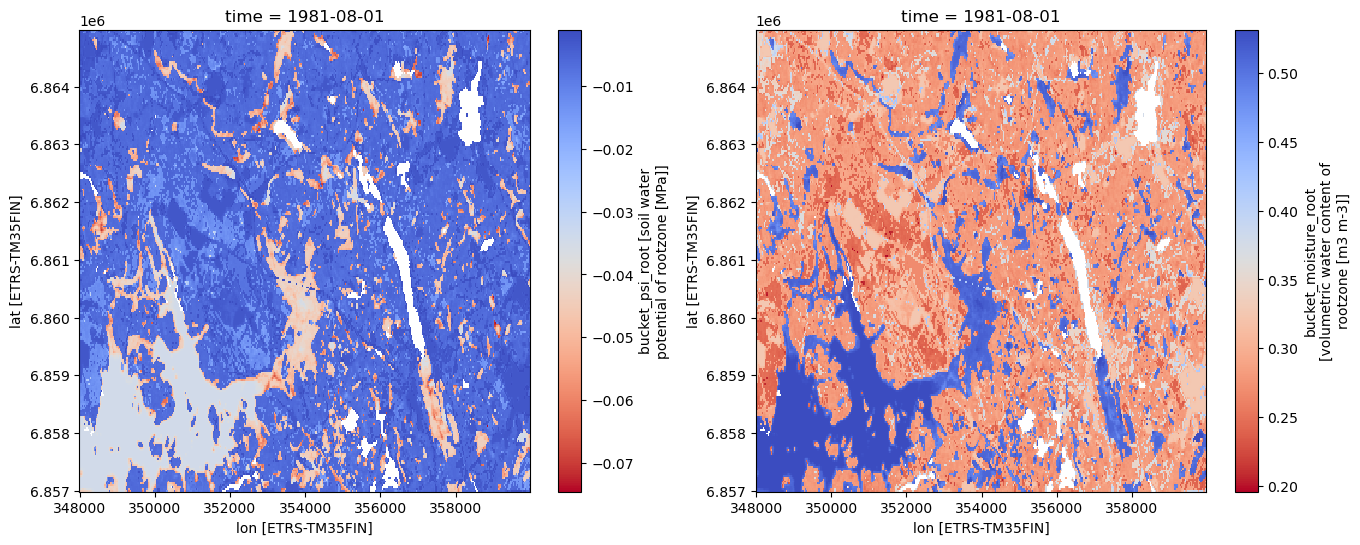

In [12]:
date = '1981-08-01'
plt.figure(figsize=(16,6))
ax=plt.subplot(1,2,1)
#results['bucket_psi_root'].sel(time=date).plot(cmap='coolwarm_r')
results['bucket_psi_root'].mean(dim=['time']).plot(vmin=-3, cmap='coolwarm_r')
plt.subplot(1,2,2, sharex=ax, sharey=ax)
#results['bucket_moisture_root'].sel(time=date)[20:-60,70:-100].plot(cmap='coolwarm_r')
results['bucket_moisture_root'].mean(dim=['time']).plot(cmap='coolwarm_r')
#results['bucket_moisture_root'].sel(time=date).plot(cmap='coolwarm_r')
#plt.subplot(1,2,3, sharex=ax, sharey=ax)
#plt.subplot(2,2,4, sharex=ax, sharey=ax)
#results['bucket_moisture_top'].sel(time=date)[20:-60,70:-100].plot(cmap='coolwarm_r')

In [1]:
import xarray as xr
file = r'/scratch/project_2000908/nousu/SpaFHy_RESULTS/testcase_input_202403121454.nc'
results = xr.open_dataset(file)

In [2]:
firedata = results[['forcing_wind_speed', 'forcing_air_temperature', 'forcing_relative_humidity', 
                    'bucket_psi_root']].copy()
results.close()

In [3]:
# subset by month
firedatass = firedata.sel(time=firedata.time.dt.month.isin([5, 6, 7, 8, 9])).copy()
# subset by snow
#firedatass = firedata.sel(time=(results['canopy_snow_water_equivalent'].max(dim=['lat','lon']) == 0)).copy()

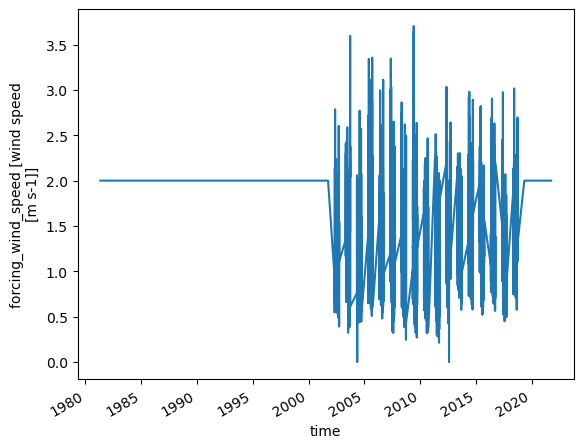

In [4]:
firedatass['forcing_wind_speed'][:].plot()

In [6]:
fp = r'/scratch/project_2000908/nousu/SpaFHy_RESULTS/spafhy_for_fire_3_24.nc'
firedatass.to_netcdf(fp, 'w')
firedatass.close()